# Big Data Strategies

Often, you'll want to take advantage of more computing power or you may have data that either has too many features or too many samples (or too many of both) to fit in memory.

Scikit-learn provides a few options for these cases.

## Streaming Instances

Many of the scikit-learn estimators provide a `fit_partial` method. You can read samples in to memory one-at-a-time or in batches.

## Feature Extraction

When the set of features is not known in advance, for example, when working with text data, you might try to extract them by making a full pass over the data. If this isn't feasible, you might try turning to the `hashing trick`.

### Aside: Hash Functions 

A hash function maps from an arbitrary size to a fixed size.

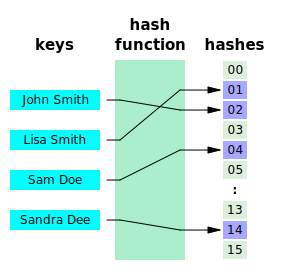

In [8]:
from IPython.display import SVG
SVG("https://upload.wikimedia.org/wikipedia/commons/7/71/Hash_table_4_1_1_0_0_0_0_LL.svg")

Python has a built-in function for this called `hash`. (You will **not** see the same numbers. Hashing in recent versions of Python is randomized for security.)

In [4]:
hash('a')

-8413618861345177091

In [2]:
hash('cuckoo')

-4752436646029469005

In [3]:
hash('cuckoo')

-4752436646029469005

But, wait, if you're mapping to a fixed range won't you have *collisions*. In principle, yes. In practice, rarely. YMMV.

### Aside: Hash Tables

Hash tables are a ubiquitous data structure when you start looking for them. The most ready example is a dictionary (or a set) in Python. This mapping data structure, formally an associative array, is often called a hash in other languages. The great thing about hash tables is that lookup and insertion is (almost always) $\mathcal{O}(1)$

This is why Python dictionary keys can't be mutable. You want the keys to always point to the same location over the life of the object.

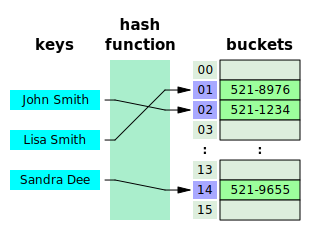

In [9]:
SVG("https://upload.wikimedia.org/wikipedia/commons/7/7d/Hash_table_3_1_1_0_1_0_0_SP.svg")

How can we take advantage of this for machine learning? Well, for one thing, you've been taking advantage of hash tables all along. This is precisely what the feature vectorizers we have been using are doing. Scikit-learn also provides a few, convenient objects for taking advange of hashing.

`FeatureHasher` applies a function to find the column index of a feature directly.

In [14]:
from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(input_type='string')

hasher.transform([
    ['a', 'simple', 'man'],
    ['pulp', 'fiction'],
    ['pride', '&', 'prejudice']
])

<3x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

`HashingVectorizer` is particularly convenient for working with documents.

In [28]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vect = HashingVectorizer(n_features=12, stop_words=['a', 'the'])

hash_vect.transform([
    'The Lion King (1994)',
    'Pulp Fiction (1994)',
    'A Simple Man (2013)',
    'Pride & Prejudice (2005))'
]).A

array([[ 0.57735027,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.57735027,  0.        ,  0.57735027,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.4472136 ,  0.        ,  0.        ,  0.        , -0.89442719,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.57735027,  0.        ,  0.57735027,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.57735027],
       [ 0.        ,  0.        ,  0.        ,  0.57735027, -0.57735027,
         0.        ,  0.        ,  0.        , -0.57735027,  0.        ,
         0.        ,  0.        ]])

In [29]:
hash_vect.transform(['(1994)']).A

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Out-of-core Learning

## Parallelism

When doing a large grid-search, or running a learning algorithm, like RandomForest, which lends itself to being fit in parallel, you may want to take advantage of 

scikit-learn provides a few options for scaling up your code to take advantage of one or more machines.

In [1]:
from multiprocessing import cpu_count
cpu_count()

4

In [ ]:
from sklearn.ensemble import RandomForestClassifier